# Simple permeation simulation

In this task, we'll go through the basics of FESTIM and run a simple permeation simulation on a 1D domain.

In [2]:
import festim as F

The first step is to create a model using a `Simulation` object.

In [3]:
my_model = F.Simulation()

In [4]:
import numpy as np

my_model.mesh = F.MeshFromVertices(
    vertices=np.linspace(0, 3e-4, num=1000)
)

`Material` objects hold the materials properties like diffusivity and solubility.

Here we only need the diffusivity defined as an Arrhenius law: $D = D_0 \exp{(-E_D/k_B T)}$ where $k_B$ is the Boltzmann constant in eV/K and $T$ is the temperature in K. From this, the pre-exponential coefficient, $D_0$ in units m<sup>2</sup>/s, and the diffusion actiavtion energy, $E_D$ in units eV are needed.`

In [5]:
my_model.materials = F.Material(id=1, D_0=1.9e-7, E_D=0.2)

In [6]:
my_model.T = F.Temperature(value=500)

In [7]:
P_up = 100

my_model.boundary_conditions = [
    F.SievertsBC(surfaces=1, S_0=4.02e21, E_S=1.04, pressure=P_up),
    F.DirichletBC(
        surfaces=2,
        value=0,   # H/m3/s
        field=0
        )
]

With `Settings` we set the main solver parameters.
- `absolute_tolerance`: the absolute tolerance of the Newton solver. For concentrations in $\mathrm{m}^{-3}$, `1e10` is usually fine.
- `relative_tolerance`: the relative tolerance of the Newton solver. Values around `1e-10` are good practices.
- `final_time`: since we want to solve a transient problem, we need to set the final time. Here, 100 s.

In [8]:
my_model.settings = F.Settings(
    absolute_tolerance=1e-2,
    relative_tolerance=1e-10,
    final_time=100  # s
    )

In [9]:
my_model.dt = F.Stepsize(initial_value=1/20)

In [10]:
derived_quantities = F.DerivedQuantities([F.HydrogenFlux(surface=2)])

my_model.exports = [derived_quantities]

In [11]:
my_model.initialise()

my_model.run()

Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        1.0e+02 s    Ellapsed time so far: 13.1 s


This problem can be solved analytically. The solution for the downstream flux is:

$$\mathrm{downstream \ flux} = \frac{P_\mathrm{up} \Phi}{L} \left(1 + 2 \sum_{n=1}^{\infty} \left(-1\right)^{n} \exp{(- \frac{\pi^{2} D n^{2} t}{L^{2}})}\right) $$

In [12]:
def downstream_flux(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): material permeability
        L (float): material thickness
        D (float): diffusivity of H in the material

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up**0.5 * permeability / L * (2*summation + 1)

We can compare the computed downstream flux to the analytical solution:

Text(0, 0.5, 'Downstream flux (H/m2/s)')

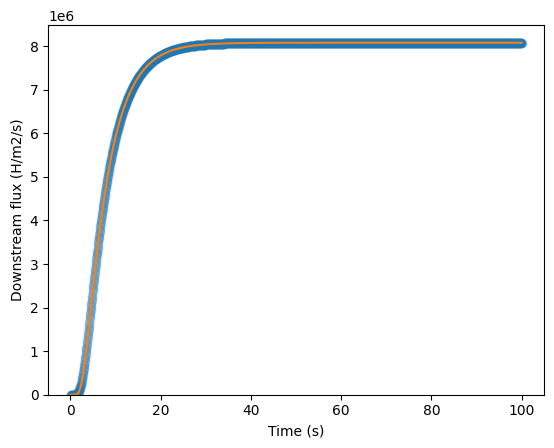

In [15]:
times = derived_quantities.t
computed_flux = derived_quantities.filter(surfaces=2).data

D = 1.9e-7*np.exp(-0.2/F.k_B/500)
S = 4.02e21*np.exp(-1.04/F.k_B/500)

import matplotlib.pyplot as plt
plt.scatter(times, np.abs(computed_flux), alpha=0.2, label="computed")
plt.plot(times, downstream_flux(times, P_up, permeability=D*S, L=3e-4, D=D), color="tab:orange", label="analytical")
plt.ylim(bottom=0)
plt.xlabel("Time (s)")
plt.ylabel("Downstream flux (H/m2/s)")